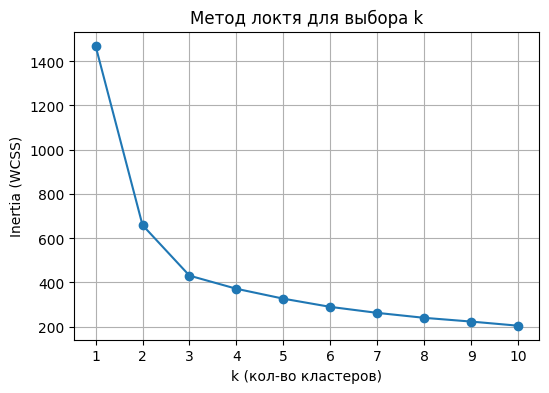

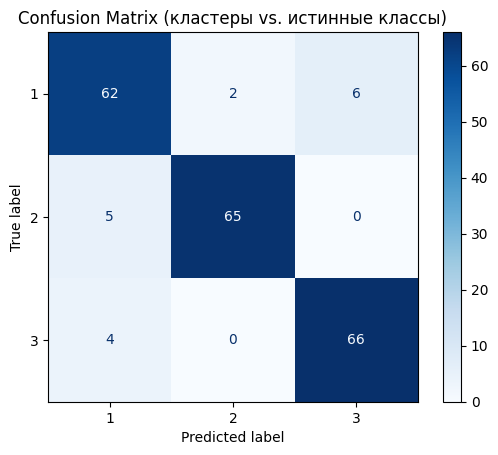

Точность кластеризации (accuracy) ≈ 0.919


In [ ]:
# =============================================
# Лабораторная №8. K-means и K-means++
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from scipy.optimize import linear_sum_assignment  # для «стыковки» кластеров и истинных меток


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
# В файле нет заголовков, разделитель — любое количество пробелов
cols = ["area_A", "perimeter_P", "compactness_C", "length_kernel_L",
        "width_kernel_W", "asymmetry_AS", "length_kernel_groove", "class"]
df = pd.read_csv(url, sep=r"\s+", header=None, names=cols)

# -------------- 3. Разделяем X и y -----------
X = df.drop("class", axis=1).values
y_true = df["class"].values  # 1, 2 или 3

# -------------- 4. Масштабируем признаки -----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------- 5. Метод локтя ---------------
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=15, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker="o")
plt.title("Метод локтя для выбора k")
plt.xlabel("k (кол-во кластеров)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_range)
plt.grid(True)
plt.show()

# На графике излом виден в районе k = 3.
k_opt = 3

# -------------- 6. Обучаем K-means++ ----------
kmeans = KMeans(
    n_clusters=k_opt,
    init="k-means++",      # ключевое отличие от классического
    n_init=30,             # больше запусков — стабильнее результат
    max_iter=300,
    random_state=42
)
y_pred = kmeans.fit_predict(X_scaled)

# -------------- 7. Сопоставляем кластеры классам
#    (кластер 0 ≠ класс 0 — надо «совместить»).
cm = confusion_matrix(y_true, y_pred)
# Hungarian algorithm ищет наилучшее соответствие
row_ind, col_ind = linear_sum_assignment(-cm)  # минус, т.к. ищем максимум

# Перенумеруем y_pred согласно найденному соответствию
mapping = {col: row for row, col in zip(row_ind, col_ind)}
y_aligned = np.vectorize(mapping.get)(y_pred)

# Итоговая матрица ошибок
cm_aligned = confusion_matrix(y_true, y_aligned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aligned,
                              display_labels=[1, 2, 3])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (кластеры vs. истинные классы)")
plt.show()

# -------------- 8. Поясняем метрику ----------
acc = np.trace(cm_aligned) / np.sum(cm_aligned)
print(f"Точность кластеризации (accuracy) ≈ {acc:.3f}")
